# **INTRODUCCIÓN**

En este archivo se presenta el desarrollo y evaluación de modelos de aprendizaje automatico con base en la presencia de enfermedades cardiacas. Para esto, usaremos el dataset CVD que contiene aproximadamenter 300,000 registros y trabajaremos sobre variables como la edad, habitos de ejercicios, condiciones medicas entre otras, con el objetivo de clasificar a los pacientes que tienen riesgo de enfermedad cardíaca y los que no.

# Importación de librerías


In [ ]:
#Librería para cargar el dataset a Google Colab
from google.colab import files

#Librerías para la manipulación del dataset
import pandas as pd
import numpy as np

#Librerías para el despliegue de gráficos
import matplotlib.pyplot as plt
import seaborn as sns

#Libreria para tratamiento de Outliers
from scipy.stats.mstats import winsorize

#Librerías para el tratamiento del desbalanceo de clases
from imblearn.over_sampling import SMOTE

#Librerías para la normalizacion y codificacion de los datos
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler

#Librerías para el entrenamiento de los modelos
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#Librerías para la evaluación del Modelo
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Carga de Dataset en un Dataframe



In [ ]:
df = pd.read_csv('CVD_dataset.csv', delimiter=',')

Saving CVD_dataset.csv to CVD_dataset.csv


In [ ]:
df.head(5)

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0


# Preprocesamiento de datos


### Tratamiento de valores nulos

In [ ]:
#Comparacion de la cantidad de datatest
print(f"Cantidad de valores nulos:", df.isnull().sum().sum())

Cantidad de valores nulos: 0


Dado que el dataset no contiene valores nulos en ninguna de sus categorías o registros, no es necesario el tratamiento de los mismos

### Analisis de graficos y Tendencias en los datos

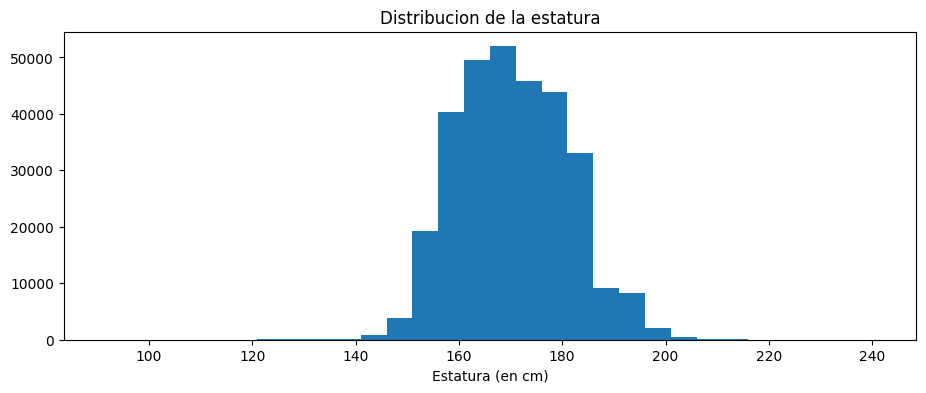

In [ ]:
plt.figure(figsize=(11, 4))
plt.hist(x=df["Height_(cm)"].to_numpy(), bins=30)
plt.title(label="Distribucion de la estatura")
plt.xlabel("Estatura (en cm)")
plt.show()

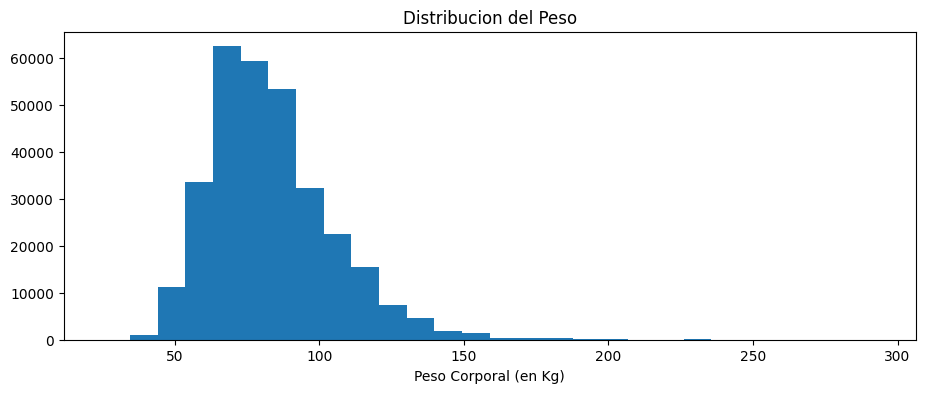

In [ ]:
plt.figure(figsize=(11, 4))
plt.hist(x=df["Weight_(kg)"].to_numpy(), bins=28)
plt.title(label="Distribucion del Peso")
plt.xlabel("Peso Corporal (en Kg)")
plt.show()

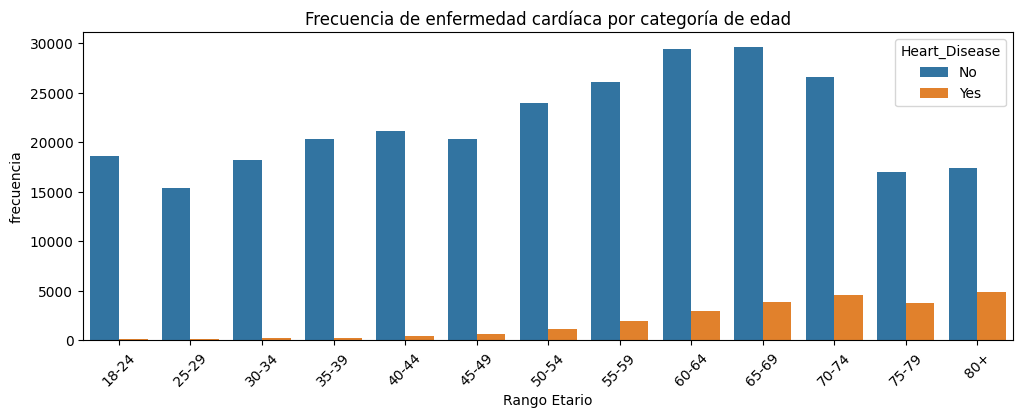

In [ ]:
edades = ["18-24", "25-29", "30-34", "35-39", "40-44", "45-49", "50-54", "55-59", "60-64", "65-69", "70-74", "75-79", "80+"]

plt.figure(figsize=(12, 4))
sns.countplot(data=df, x='Age_Category', hue='Heart_Disease', order=edades)
plt.title('Frecuencia de enfermedad cardíaca por categoría de edad')
plt.xlabel(xlabel="Rango Etario")
plt.ylabel(ylabel="frecuencia")
plt.xticks(rotation=45)
plt.show()

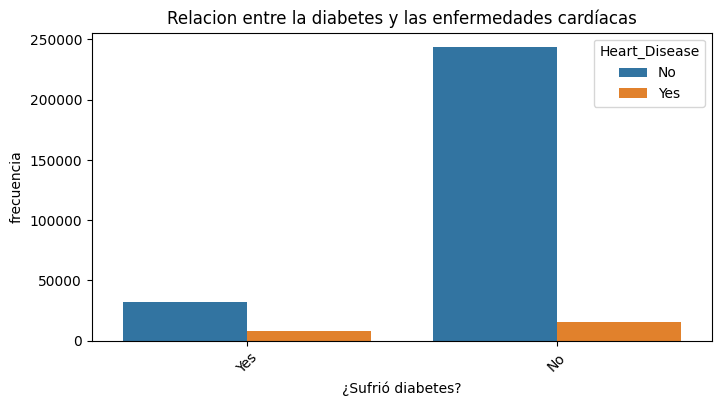

In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='Diabetes', hue='Heart_Disease', order = ["Yes", "No"])
plt.title('Relacion entre la diabetes y las enfermedades cardíacas')
plt.xlabel(xlabel="¿Sufrió diabetes?")
plt.ylabel(ylabel="frecuencia")
plt.xticks(rotation=45)
plt.show()

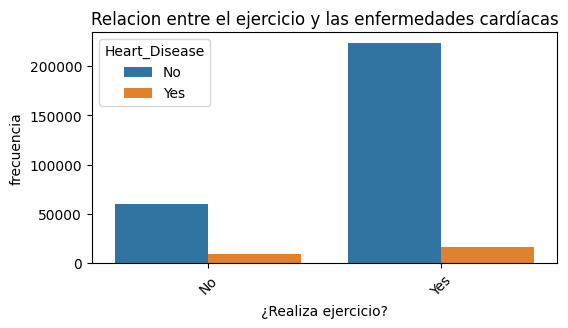

In [ ]:
plt.figure(figsize=(6, 3))
sns.countplot(data=df, x='Exercise', hue='Heart_Disease')
plt.title('Relacion entre el ejercicio y las enfermedades cardíacas')
plt.xlabel(xlabel="¿Realiza ejercicio?")
plt.ylabel(ylabel="frecuencia")
plt.xticks(rotation=45)
plt.show()

**OUTLIERS DE DATATEST**

Primero veo los outliers mediante el método IQR

In [ ]:
columnas_numericas = df.select_dtypes(include=[np.number]).columns
outliers_antes = {}

for columna in columnas_numericas:
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1

    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]
    outliers_antes[columna] = len(outliers)

    print(f"{columna}: {len(outliers)} outliers detectados ({len(outliers)/len(df)*100:.2f}%)")

Height_(cm): 1055 outliers detectados (0.34%)
Weight_(kg): 7326 outliers detectados (2.37%)
BMI: 9530 outliers detectados (3.09%)
Alcohol_Consumption: 36147 outliers detectados (11.70%)
Fruit_Consumption: 68225 outliers detectados (22.09%)
Green_Vegetables_Consumption: 11878 outliers detectados (3.85%)
FriedPotato_Consumption: 19456 outliers detectados (6.30%)


Como se puede apreciar, los outlier son variados y no parejos. Así que solamente eliminamos los valores extremos para emparejar todo. Esto usando la winsorización.

In [ ]:
df_winsorized = df.copy()

for col in columnas_numericas:
    valores_originales = df[col].copy()

    df_winsorized[col] = winsorize(df[col], limits=[0.005, 0.005])

    valores_cambiados = (valores_originales != df_winsorized[col]).sum()

    #Comparacion por variable
    print(f"{col}:")
    print(f"  Valores modificados: {valores_cambiados} ({valores_cambiados/len(df)*100:.2f}%)")
    print(f"  Rango ANTES: [{valores_originales.min():.2f}, {valores_originales.max():.2f}]")
    print(f"  Rango DESPUÉS: [{df_winsorized[col].min():.2f}, {df_winsorized[col].max():.2f}]")
    print()



Height_(cm):
  Valores modificados: 2533 (0.82%)
  Rango ANTES: [91.00, 241.00]
  Rango DESPUÉS: [147.00, 196.00]

Weight_(kg):
  Valores modificados: 2746 (0.89%)
  Rango ANTES: [24.95, 293.02]
  Rango DESPUÉS: [45.36, 158.76]

BMI:
  Valores modificados: 3054 (0.99%)
  Rango ANTES: [12.02, 99.33]
  Rango DESPUÉS: [17.17, 53.25]

Alcohol_Consumption:
  Valores modificados: 0 (0.00%)
  Rango ANTES: [0.00, 30.00]
  Rango DESPUÉS: [0.00, 30.00]

Fruit_Consumption:
  Valores modificados: 0 (0.00%)
  Rango ANTES: [0.00, 120.00]
  Rango DESPUÉS: [0.00, 120.00]

Green_Vegetables_Consumption:
  Valores modificados: 845 (0.27%)
  Rango ANTES: [0.00, 128.00]
  Rango DESPUÉS: [0.00, 90.00]

FriedPotato_Consumption:
  Valores modificados: 763 (0.25%)
  Rango ANTES: [0.00, 128.00]
  Rango DESPUÉS: [0.00, 60.00]



Por último vemos las comparaciones

In [ ]:
#Comparacion en cuadro
comparison_data = []
for col in columnas_numericas:
    comparison_data.append({
        'Variable': col,
        'Media_Antes': df[col].mean(),
        'Media_Después': df_winsorized[col].mean(),
        'Mediana_Antes': df[col].median(),
        'Mediana_Después': df_winsorized[col].median(),
        'Std_Antes': df[col].std(),
        'Std_Después': df_winsorized[col].std(),
        'Min_Antes': df[col].min(),
        'Min_Después': df_winsorized[col].min(),
        'Max_Antes': df[col].max(),
        'Max_Después': df_winsorized[col].max()
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

                    Variable  Media_Antes  Media_Después  Mediana_Antes  Mediana_Después  Std_Antes  Std_Después  Min_Antes  Min_Después  Max_Antes  Max_Después
                 Height_(cm)   170.615249     170.628996         170.00           170.00  10.658026    10.487112      91.00       147.00     241.00       196.00
                 Weight_(kg)    83.588655      83.500130          81.65            81.65  21.343210    20.835827      24.95        45.36     293.02       158.76
                         BMI    28.626211      28.596218          27.44            27.44   6.522323     6.332067      12.02        17.17      99.33        53.25
         Alcohol_Consumption     5.096366       5.096366           1.00             1.00   8.199763     8.199763       0.00         0.00      30.00        30.00
           Fruit_Consumption    29.835200      29.835200          30.00            30.00  24.875735    24.875735       0.00         0.00     120.00       120.00
Green_Vegetables_Consumption    15

In [ ]:
#Comparacion de la cantidad de registros del datatest
print(f"  Original: {df.shape}")
print(f"  Después de winsorización: {df_winsorized.shape}")

  Original: (308854, 19)
  Después de winsorización: (308854, 19)


In [ ]:
#Comparacion de valores nulos
print(f"  Antes: {df.isnull().sum().sum()}")
print(f"  Después: {df_winsorized.isnull().sum().sum()}")

  Antes: 0
  Después: 0


## Normalización y Codificación

### Codificación de variables categóricas

Para las variables Exercise, Skin_Cancer, Other_Cancer, Depression, Diabetes, Arthritis, Sex y Smoking_History se utilizará one-hot encoding ya que sus valores no tienen un orden aparente y presentan baja cardinalidad (Diabetes es la única que tiene cuatro valores posibles en vez de dos).

In [ ]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output= False)

columnas_one_hot = [
    "Exercise", "Skin_Cancer", "Other_Cancer","Depression",
    "Diabetes", "Arthritis", "Sex", "Smoking_History"
]

for col in columnas_one_hot:
  datasetEncoded = encoder.fit_transform(df_winsorized[[col]])
  colColumns = encoder.get_feature_names_out([col])
  datasetEncoded = pd.DataFrame(datasetEncoded, columns=colColumns)

  df_winsorized.reset_index(drop= True, inplace= True)
  datasetEncoded.reset_index(drop= True, inplace= True)

  df_winsorized = pd.concat([df_winsorized, datasetEncoded], axis=1)

  df_winsorized = df_winsorized.drop(col, axis=1)

  df_winsorized["Heart_Disease"] = df_winsorized["Heart_Disease"].replace(to_replace="Yes", value=1)
  df_winsorized["Heart_Disease"] = df_winsorized["Heart_Disease"].replace(to_replace="No", value=0)

/tmp/ipython-input-1651273735.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_winsorized["Heart_Disease"] = df_winsorized["Heart_Disease"].replace(to_replace="No", value=0)


El resto de variables categóricas, General_Health, Checkup y Age_Category, tienen un orden definido, por lo tanto, aplicaremos ordinal encoding.

In [ ]:
columnas_ordinal = ["General_Health", "Checkup", "Age_Category"]
categorias= [
    ["Poor", "Fair", "Good", "Very Good", "Excellent",],
    ["Never", "5 or more years ago", "Within the past 5 years", "Within the past 2 years", "Within the past year"],
    ["80+", "75-79", "70-74", "65-69", "60-64", "55-59", "50-54", "45-49", "40-44", "35-39", "30-34", "25-29", "18-24"]
]

encoder = OrdinalEncoder(categories = categorias)

df_winsorized[columnas_ordinal] = encoder.fit_transform(df_winsorized[columnas_ordinal])

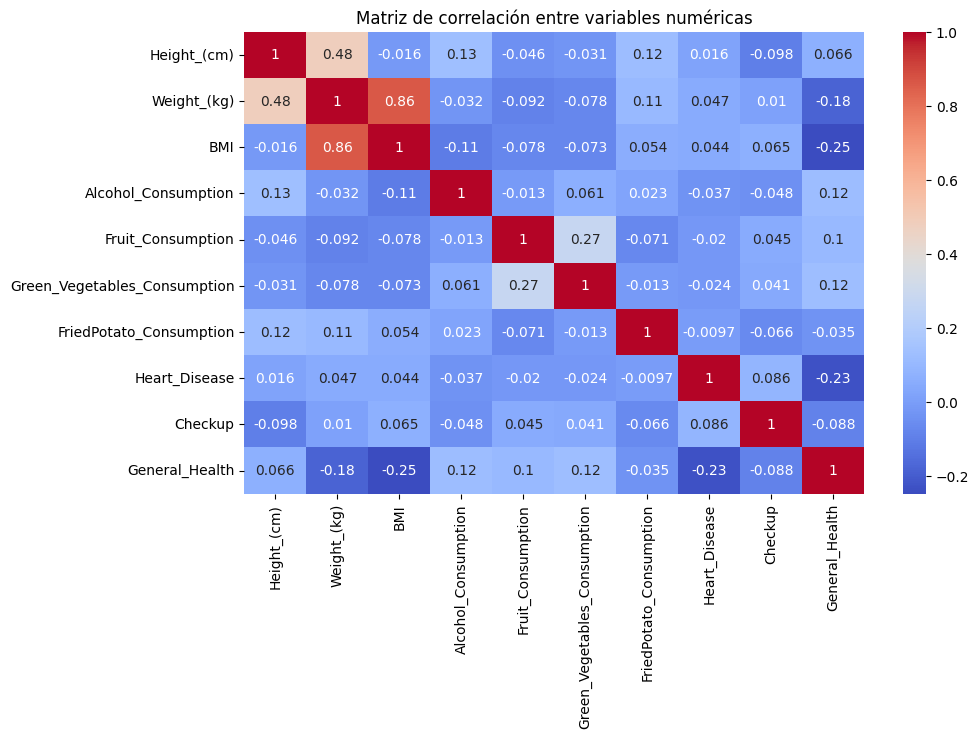

In [ ]:
cols = ['Height_(cm)', 'Weight_(kg)', 'BMI',
            'Alcohol_Consumption', 'Fruit_Consumption',
            'Green_Vegetables_Consumption', 'FriedPotato_Consumption', "Heart_Disease", "Checkup", "General_Health"]

corr = df_winsorized[cols].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Matriz de correlación entre variables numéricas')
plt.show()

Seleccionamos cuáles serán los features que alimentarán al modelo, y cuál es el target.

In [ ]:
X = df_winsorized.drop("Heart_Disease", axis=1) #guarda los features
y = df_winsorized["Heart_Disease"] #guarda el target

X.head()
print(y.head())

0    0
1    1
2    0
3    1
4    0
Name: Heart_Disease, dtype: int64


## Balanceo de clases

Al ejecutar el siguiente código, como podemos apreciar, observamos que hay un claro desbalance entre la cantidad de casos en los que un paciente presenta enfermedades cardíacas y los que no.

In [ ]:

print("Distribución de clases:")
print(y.value_counts())
print("----------------------------------")

Distribución de clases:
Heart_Disease
0    283883
1     24971
Name: count, dtype: int64
----------------------------------


Por lo tanto, es necesario tratar este desbalance para evitar que el modelo termine prediciendo correctamente solo los casos negativos (reflejado en el recall y la precision).



In [ ]:
smote = SMOTE(sampling_strategy='all')

x_resampled, y_resampled = smote.fit_resample(X, y)

A continuación, dividimos el dataset en dos conjuntos que se utilizarán para training y testing respectivamente(Train-Test Split), con el fin de minimizar el overfitting y el underfitting. Además, vale aclarar que hacer esta división antes de la estandarizacion de datos es clave para evitar data leakeage y obtener métricas realistas.

En este caso, como el dataset es grande(más de 300000 registros) aplicaremos un split de 90-10%.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.10, random_state=101)

### Normalización de datos numéricos

Se utilizará estandarizacion Z-score para los datos ya que la mayoría de los valores numéricos presentan una distribucion normal y, en cierto grado, valores atípicos.

In [ ]:
scaler = StandardScaler()

X_train[columnas_numericas] = scaler.fit_transform(X_train[columnas_numericas])
X_test[columnas_numericas] = scaler.transform(X_test[columnas_numericas])

# Entrenamiento del Modelo

### Regresión Logística

In [ ]:
modeloRL = LogisticRegression(class_weight="balanced")
modeloRL.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

### Support Vector Machine (SVM)

In [ ]:
modeloSVM = LinearSVC(class_weight='balanced', max_iter=2000)
modeloSVM.fit(X=X_train, y=y_train)

LinearSVC(class_weight='balanced', max_iter=2000)

### K Nearest Neighbours (K-NN)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=2, weights="distance")
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2, weights='distance')

### Decision Tree

In [ ]:
decTree = DecisionTreeClassifier(max_depth=34)
decTree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=34)

### Random Forest

In [ ]:
ranForest = RandomForestClassifier(class_weight="balanced", n_estimators=90, max_depth=36)
ranForest.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=36, n_estimators=90)

# Evaluacion del Modelo

In [ ]:
resumenEvalModelos = pd.DataFrame(columns=["Modelo", "Accuracy", "Recall", "Precision", "F1-score"])

In [ ]:
prediccionDecTree = decTree.predict(X_test)

accDecTree = round(accuracy_score(y_test, prediccionDecTree), 4)
recallDecTree = round(recall_score(y_test, prediccionDecTree, pos_label=1), 4)
precDecTree = round(precision_score(y_test, prediccionDecTree, pos_label=1), 4)
F1_DecTree = round(f1_score(y_test, prediccionDecTree, pos_label=1), 4)

resumenEvalModelos.loc[len(resumenEvalModelos)] = ["Decision Tree", accDecTree, recallDecTree, precDecTree, F1_DecTree]

In [ ]:
prediccionRanFor = ranForest.predict(X_test)

accRanForest = round(accuracy_score(y_test, prediccionRanFor), 4)
recallRanForest = round(recall_score(y_test, prediccionRanFor, pos_label=1), 4)
precRanForest = round(precision_score(y_test, prediccionRanFor, pos_label=1), 4)
F1_RanForest = round(f1_score(y_test, prediccionRanFor, pos_label=1), 4)

resumenEvalModelos.loc[len(resumenEvalModelos)] = ["Random Forest", accRanForest, recallRanForest, precRanForest, F1_RanForest]

In [ ]:
prediccionSVM = modeloSVM.predict(X_test)

accSVM = round(accuracy_score(y_test, prediccionSVM), 4)
recallSVM = round(recall_score(y_test, prediccionSVM, pos_label=1), 4)
precSVM = round(precision_score(y_test, prediccionSVM, pos_label=1), 4)
F1_SVM = round(f1_score(y_test, prediccionSVM, pos_label=1), 4)

resumenEvalModelos.loc[len(resumenEvalModelos)] = ["SVM", accSVM, recallSVM, precSVM, F1_SVM]

In [ ]:
prediccionKnn = knn.predict(X_test)

accKNN = round(accuracy_score(y_test, prediccionKnn), 4)
recallKNN = round(recall_score(y_test, prediccionKnn, pos_label=1), 4)
precKNN = round(precision_score(y_test, prediccionKnn, pos_label=1), 4)
F1_KNN = round(f1_score(y_test, prediccionKnn, pos_label=1), 4)

resumenEvalModelos.loc[len(resumenEvalModelos)] = ["K-NN", accKNN, recallKNN, precKNN, F1_KNN]

#Aviso: tarda alrededor de tres minutos

In [ ]:
prediccionRL = modeloRL.predict(X_test)

accRL = round(accuracy_score(y_test, prediccionRL), 4)
recallRL = round(recall_score(y_test, prediccionRL, pos_label=1), 4)
precRL = round(precision_score(y_test, prediccionRL, pos_label=1), 4)
F1_RL = round(f1_score(y_test, prediccionRL, pos_label=1), 4)

resumenEvalModelos.loc[len(resumenEvalModelos)] = ["Regresion Logistica", accRL, recallRL, precRL, F1_RL]

In [ ]:
print(resumenEvalModelos)

                Modelo  Accuracy  Recall  Precision  F1-score
0        Decision Tree    0.9267  0.9348     0.9197    0.9272
1        Random Forest    0.9573  0.9212     0.9928    0.9557
2                  SVM    0.7812  0.8298     0.7557    0.7911
3                 K-NN    0.9384  0.9932     0.8950    0.9415
4  Regresion Logistica    0.7804  0.8196     0.7593    0.7883


# **Conclusión**

Elegimos el modelo K-NN (con k = 2 y weights = "Distance") ya que es el que presenta un F1-Score y un Accuracy adecuados, pero, sobre todo, porque tiene el mayor Recall (un poco superior a 0.99). Esta métrica es especialmente importante en este caso, ya que, en los modelos relacionados con el diagnóstico de problemas (ya sean de salud, financieros, mecánicos, etcétera) los errores relacionados con los Falsos Negativos son mucho mas peligrosos y/o costosos que aquellos relacionados con Falsos Positivos.